In [1]:
!nvidia-smi

Sun Jan  7 05:27:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:8A:00.0 Off |                  N/A |
|  0%   30C    P8              16W / 350W |      2MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [5]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Dataset

In [8]:
data_dir = './DATA/rawdata'
dataset_name = 'translation2019'
prefix = Path(data_dir).absolute() / dataset_name

## Language

In [9]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [10]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Slipshod assistance , foolish inattention , dowdy indifference , & halfhearted work seem the rule ;
The product adopt outstanding black extinction cloth with soft nap on the inner side , to eliminate the environment light disturbance and the monitor light selfreflection effectively .
Europe has about 5 . 3 million rooms .
Note:Cover for cable tray Modle T103 is available . In making an order , just indicate the tape of cover whose weight is exclusive .
A pound doesn't go far these days .
工作上拖拖拉拉、漫不经心、三心二意似乎已成常态 ;
产品内侧采用性能优异的黑色消光绒面 , 有效的消除环境光线的干扰和显示器自身光线的反射 。
欧洲的客房更高达530万间 。
注:T1-03弯通桥架备有护罩 , 需订护罩请在订货时按型号注明 , 重量另计 。
现今一英镑不经一用 。


## Preprocess files

In [11]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [12]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [13]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Slipshod assistance , foolish inattention , dowdy indifference , & halfhearted work seem the rule ;
The product adopt outstanding black extinction cloth with soft nap on the inner side , to eliminate the environment light disturbance and the monitor light selfreflection effectively .
Europe has about 5 . 3 million rooms .
Note:Cover for cable tray Modle T103 is available . In making an order , just indicate the tape of cover whose weight is exclusive .
A pound doesn't go far these days .
工作上拖拖拉拉、漫不经心、三心二意似乎已成常态 ;
产品内侧采用性能优异的黑色消光绒面 , 有效的消除环境光线的干扰和显示器自身光线的反射 。
欧洲的客房更高达530万间 。
注:T1-03弯通桥架备有护罩 , 需订护罩请在订货时按型号注明 , 重量另计 。
现今一英镑不经一用 。


## Split into train/valid

In [14]:
valid_ratio = 0.01 
train_ratio = 1 - valid_ratio

In [15]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

## Subword Units 

In [ ]:
import sentencepiece as spm
vocab_size = 32000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

In [17]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

In [18]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁slip sh od ▁assistance ▁, ▁foolish ▁in att ent ion ▁, ▁dow dy ▁in di ffer ence ▁, ▁& ▁half hearted ▁work ▁seem ▁the ▁rule ▁;
▁the ▁product ▁adopt ▁outstanding ▁black ▁extinction ▁cloth ▁with ▁soft ▁nap ▁on ▁the ▁inner ▁side ▁, ▁to ▁eliminate ▁the ▁environment ▁light ▁disturbance ▁and ▁the ▁monitor ▁light ▁self re fl ection ▁effective ly ▁.
▁europe ▁has ▁about ▁5 ▁. ▁3 ▁million ▁rooms ▁.
▁note : cover ▁for ▁cable ▁tray ▁ mod le ▁t 10 3 ▁is ▁available ▁. ▁in ▁making ▁an ▁order ▁, ▁just ▁indicate ▁the ▁tape ▁of ▁cover ▁whose ▁weight ▁is ▁exclusive ▁.
▁a ▁pound ▁doesn ' t ▁go ▁far ▁these ▁days ▁.
▁ 工作 上 拖 拖 拉 拉 、 漫 不 经 心 、 三 心 二 意 似乎 已 成 常 态 ▁;
▁产品 内 侧 采用 性能 优异 的 黑色 消 光 绒 面 ▁, ▁ 有效的 消除 环境 光线 的 干扰 和 显示器 自身 光线 的 反射 ▁。
▁欧洲 的 客房 更 高达 5 30 万 间 ▁。
▁ 注 : t 1 - 03 弯 通 桥 架 备 有 护 罩 ▁, ▁ 需 订 护 罩 请 在 订 货 时 按 型号 注 明 ▁, ▁ 重量 另 计 ▁。
▁ 现今 一 英镑 不 经 一 用 ▁。


## Binarize the data with fairseq

In [ ]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

# Configuration for experiments

In [20]:
config = Namespace(
    datadir = "./DATA/data-bin/translation2019",
    # savedir = "./checkpoints/rnn",
    savedir = "./checkpoints/transformer",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [21]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [22]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2024-01-06 23:45:20 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2024-01-06 23:45:20 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 23.691 GB ; name = NVIDIA GeForce RTX 3090                 
2024-01-06 23:45:20 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

In [23]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2024-01-06 23:45:25 | INFO | fairseq.tasks.translation | [en] dictionary: 33624 types
2024-01-06 23:45:25 | INFO | fairseq.tasks.translation | [zh] dictionary: 33624 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True)
task.load_dataset(split="valid", epoch=1)

In [25]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([2586,   47, 5767,  720, 4029, 1242,   94,   19,    5, 9448,  414,    4,
        1281,   23,   13,    5,  305,  414,    7,    2]),
 'target': tensor([    6, 19860,   533,    47,     4,     6,  9098,   599,    11, 27324,
         5477,     4,     6,    18,  7389,  2573,    38,   881,    11,     8,
            2])}
('Source: remember ? alcoholism rates went up for the intervention group , '
 'compared to the control group .')
'Target: 还记得吗 ? , 干预组的酗酒比例 , 和对照组相比是增加的 。'


# Dataset iterator

In [26]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2024-01-06 23:45:40 | WARNING | fairseq.tasks.fairseq_task | 14,324 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[16343, 10080, 9181, 3595, 12852, 9309, 12384, 7888, 2956, 4638]


{'id': tensor([18143]),
 'nsentences': 1,
 'ntokens': 10,
 'net_input': {'src_tokens': tensor([[    1,     1,     1,    37,   903,     5, 14352,   211, 12669,    17,
             244,  1443,  4955,   321,     7,     2]]),
  'src_lengths': tensor([13]),
  'prev_output_tokens': tensor([[    2,   233,  2599, 14562, 18929,    38,   658,  1209,    11,     8,
               1,     1,     1,     1,     1,     1]])},
 'target': tensor([[  233,  2599, 14562, 18929,    38,   658,  1209,    11,     8,     2,
              1,     1,     1,     1,     1,     1]])}

# Model Architecture

In [27]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [31]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [32]:
# transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

In [33]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.15,
)

def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [34]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [35]:
model = build_model(arch_args, task)
logger.info(model)

2024-01-06 23:45:55 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(33624, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=2

# Optimization

## Loss: Label Smoothing Regularization

In [36]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling

In [37]:
def get_rate(d_model, step_num, warmup_step):
    lr = (d_model**(-0.5)) * min(step_num**(-0.5), step_num*(warmup_step**(-1.5)))
    return lr

In [38]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

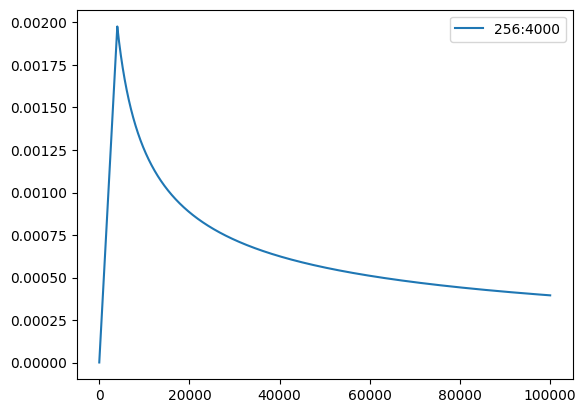

In [39]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [40]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference

In [41]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [42]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [43]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
        print(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [44]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [45]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2024-01-06 23:46:20 | INFO | hw5.seq2seq | task: TranslationTask
2024-01-06 23:46:20 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2024-01-06 23:46:20 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2024-01-06 23:46:20 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2024-01-06 23:46:20 | INFO | hw5.seq2seq | optimizer: NoamOpt
2024-01-06 23:46:20 | INFO | hw5.seq2seq | num. model params: 24,589,312 (num. trained: 24,589,312)
2024-01-06 23:46:20 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [46]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2024-01-06 23:46:23 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer/checkpoint_last.pt!


train epoch 1:   0%|          | 0/3296 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


2024-01-06 23:55:27 | INFO | hw5.seq2seq | training loss: 6.3910
2024-01-06 23:55:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-06 23:56:56 | INFO | hw5.seq2seq | example source: even very experienced photographers have many bad timing shots for this type of image .
2024-01-06 23:56:56 | INFO | hw5.seq2seq | example hypothesis: 即使是非常经验的摄影师 , 有许多糟糕的时机在这种类型的图像中 。
2024-01-06 23:56:56 | INFO | hw5.seq2seq | example reference: 就算资深摄影师在拍摄这种图片时也要经历很多次失败 。
2024-01-06 23:56:56 | INFO | hw5.seq2seq | validation loss:	4.7977
2024-01-06 23:56:56 | INFO | hw5.seq2seq | BLEU = 16.81 57.1/29.0/15.7/9.1 (BP = 0.762 ratio = 0.787 hyp_len = 517978 ref_len = 658487)
2024-01-06 23:56:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint1.pt
2024-01-06 23:56:56 | INFO | hw5.seq2seq | end of epoch 1


train epoch 2:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 00:06:05 | INFO | hw5.seq2seq | training loss: 4.6568
2024-01-07 00:06:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 00:07:36 | INFO | hw5.seq2seq | example source: he served in the marine corps as an intelligence officer and deployed to afghanistan in 2003 , 2004 , and 2005 .
2024-01-07 00:07:36 | INFO | hw5.seq2seq | example hypothesis: 他于2003年在海军陆战队服役 , 并于2003年部署到阿富汗 , 2004年 , 2005年和2005年 。
2024-01-07 00:07:36 | INFO | hw5.seq2seq | example reference: 他是海军陆战队的情报官员 , 2003、2004和2005年随军队部署到阿富汗 。
2024-01-07 00:07:36 | INFO | hw5.seq2seq | validation loss:	4.3114
2024-01-07 00:07:36 | INFO | hw5.seq2seq | BLEU = 21.92 59.4/32.2/18.6/11.4 (BP = 0.869 ratio = 0.877 hyp_len = 577221 ref_len = 658487)
2024-01-07 00:07:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint2.pt
2024-01-07 00:07:36 | INFO | hw5.seq2seq | end of epoch 2


train epoch 3:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 00:16:46 | INFO | hw5.seq2seq | training loss: 4.3539
2024-01-07 00:16:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 00:18:23 | INFO | hw5.seq2seq | example source: a woman with a wad of coca in her left cheek—a figurine from a sacrificial burial—is one of the rare surviving pieces of inca artifact .
2024-01-07 00:18:23 | INFO | hw5.seq2seq | example hypothesis: 一个女人 , 她左脸颊上wad的coca , 一个女人从牺牲的墓葬中 , 是一个罕见幸存的印卡文物之一 。
2024-01-07 00:18:23 | INFO | hw5.seq2seq | example reference: 一尊来自祭祀葬礼的女性雕像 , 她左边的面颊里还塞着一团古柯叶 。 它是少数幸存下来的印加手工艺品之一 。
2024-01-07 00:18:23 | INFO | hw5.seq2seq | validation loss:	4.1616
2024-01-07 00:18:23 | INFO | hw5.seq2seq | BLEU = 23.73 59.6/32.9/19.4/12.1 (BP = 0.911 ratio = 0.915 hyp_len = 602429 ref_len = 658487)
2024-01-07 00:18:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint3.pt
2024-01-07 00:18:24 | INFO | hw5.seq2seq | end of epoch 3


train epoch 4:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 00:27:28 | INFO | hw5.seq2seq | training loss: 4.2346
2024-01-07 00:27:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 00:28:59 | INFO | hw5.seq2seq | example source: the mathematical model for aircraft engine , heat exchanger , duct , venturi , valve and other components in aircraft environment control system is described in this paper .
2024-01-07 00:28:59 | INFO | hw5.seq2seq | example hypothesis: 介绍了飞机发动机、换热器、管道、阀门等部件在飞机环境控制系统的数学模型 。
2024-01-07 00:28:59 | INFO | hw5.seq2seq | example reference: 介绍了飞机环境控制系统中发动机引气、热交换器、管道、文氏管以及阀门等部件的数学模型 。
2024-01-07 00:28:59 | INFO | hw5.seq2seq | validation loss:	4.0912
2024-01-07 00:28:59 | INFO | hw5.seq2seq | BLEU = 24.11 61.2/34.4/20.5/13.0 (BP = 0.881 ratio = 0.887 hyp_len = 584361 ref_len = 658487)
2024-01-07 00:28:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint4.pt
2024-01-07 00:28:59 | INFO | hw5.seq2seq | end of epoch 4


train epoch 5:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 00:38:02 | INFO | hw5.seq2seq | training loss: 4.1676
2024-01-07 00:38:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 00:39:34 | INFO | hw5.seq2seq | example source: its survival has been threatened by the appearance of another plant , an invasive species called european beachgrass .
2024-01-07 00:39:34 | INFO | hw5.seq2seq | example hypothesis: 它的生存受到另一个植物的威胁 , 一种叫做欧洲海滩草的入侵物种 。
2024-01-07 00:39:34 | INFO | hw5.seq2seq | example reference: 它的生存由于另一个植物的出现而受到了威胁 , 这是个带有侵略性的物种被称作欧洲喜沙草属 。
2024-01-07 00:39:34 | INFO | hw5.seq2seq | validation loss:	4.0358
2024-01-07 00:39:34 | INFO | hw5.seq2seq | BLEU = 24.84 60.6/34.2/20.5/13.1 (BP = 0.910 ratio = 0.914 hyp_len = 601951 ref_len = 658487)
2024-01-07 00:39:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint5.pt
2024-01-07 00:39:34 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 00:48:40 | INFO | hw5.seq2seq | training loss: 4.1232
2024-01-07 00:48:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 00:50:11 | INFO | hw5.seq2seq | example source: look at all the data that goes into protein folding .
2024-01-07 00:50:11 | INFO | hw5.seq2seq | example hypothesis: 看看蛋白质折叠的所有数据 。
2024-01-07 00:50:11 | INFO | hw5.seq2seq | example reference: 看看所有进入蛋白质折叠【译注】的数据 。
2024-01-07 00:50:11 | INFO | hw5.seq2seq | validation loss:	4.0080
2024-01-07 00:50:11 | INFO | hw5.seq2seq | BLEU = 24.65 62.2/35.4/21.3/13.6 (BP = 0.872 ratio = 0.879 hyp_len = 578986 ref_len = 658487)
2024-01-07 00:50:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint6.pt
2024-01-07 00:50:11 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 00:59:18 | INFO | hw5.seq2seq | training loss: 4.0915
2024-01-07 00:59:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 01:00:47 | INFO | hw5.seq2seq | example source: if i wear this dress , then john might ask me out !
2024-01-07 01:00:47 | INFO | hw5.seq2seq | example hypothesis: 如果我穿这件衣服 , 那么约翰可能会问我出去 !
2024-01-07 01:00:47 | INFO | hw5.seq2seq | example reference: 她穿那件洋装的那天 , 约翰会约她出去 。
2024-01-07 01:00:47 | INFO | hw5.seq2seq | validation loss:	3.9823
2024-01-07 01:00:47 | INFO | hw5.seq2seq | BLEU = 25.25 61.4/34.9/21.1/13.5 (BP = 0.905 ratio = 0.909 hyp_len = 598556 ref_len = 658487)
2024-01-07 01:00:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint7.pt
2024-01-07 01:00:48 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 01:09:54 | INFO | hw5.seq2seq | training loss: 4.0666
2024-01-07 01:09:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 01:11:24 | INFO | hw5.seq2seq | example source: the solvent effects on the nonlinear optical properties of para nitroaniline molecule are studied on the base of time dependent density functional theory .
2024-01-07 01:11:24 | INFO | hw5.seq2seq | example hypothesis: 在时间依赖密度函数理论的基础上 , 研究了溶剂对亚硝基苯胺分子的非线性光学性质的影响 。
2024-01-07 01:11:24 | INFO | hw5.seq2seq | example reference: 在含时密度泛函理论水平上研究了溶剂对硝基苯胺分子非线性光学性质的影响 。
2024-01-07 01:11:24 | INFO | hw5.seq2seq | validation loss:	3.9684
2024-01-07 01:11:24 | INFO | hw5.seq2seq | BLEU = 25.28 62.3/35.6/21.6/13.9 (BP = 0.886 ratio = 0.892 hyp_len = 587366 ref_len = 658487)
2024-01-07 01:11:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint8.pt
2024-01-07 01:11:24 | INFO | hw5.seq2seq | end of epoch 8


train epoch 9:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 01:20:29 | INFO | hw5.seq2seq | training loss: 4.0474
2024-01-07 01:20:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 01:21:58 | INFO | hw5.seq2seq | example source: the warm , humid climate makes hainan a bounty of tropical crops — the island is an important producer of pineapples , coconuts , mangoes , sugar cane , coffee and rubber trees .
2024-01-07 01:21:58 | INFO | hw5.seq2seq | example hypothesis: 温暖潮湿的气候使海南成为热带作物的盛宴 , 岛是菠萝、椰子、芒果、甘蔗、咖啡和橡胶树的重要生产地 。
2024-01-07 01:21:58 | INFO | hw5.seq2seq | example reference: 温暖湿润的气候使海南的热带植物繁茂海南岛是菠萝、可可豆、芒果、甘蔗、咖啡和橡胶的重要产地 。
2024-01-07 01:21:58 | INFO | hw5.seq2seq | validation loss:	3.9575
2024-01-07 01:21:58 | INFO | hw5.seq2seq | BLEU = 25.01 63.0/36.1/22.0/14.2 (BP = 0.861 ratio = 0.870 hyp_len = 572644 ref_len = 658487)
2024-01-07 01:21:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint9.pt
2024-01-07 01:21:58 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 01:31:06 | INFO | hw5.seq2seq | training loss: 4.0316
2024-01-07 01:31:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 01:32:37 | INFO | hw5.seq2seq | example source: you can use different approaches to introduce your new webservice to your visitors .
2024-01-07 01:32:37 | INFO | hw5.seq2seq | example hypothesis: 您可以使用不同的方法将新web服务引入到您的访问者 。
2024-01-07 01:32:37 | INFO | hw5.seq2seq | example reference: 你可以通过不同的途径向你的访问者介绍网站服务 。
2024-01-07 01:32:37 | INFO | hw5.seq2seq | validation loss:	3.9417
2024-01-07 01:32:37 | INFO | hw5.seq2seq | BLEU = 25.45 62.0/35.4/21.5/13.8 (BP = 0.895 ratio = 0.900 hyp_len = 592590 ref_len = 658487)
2024-01-07 01:32:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint10.pt
2024-01-07 01:32:38 | INFO | hw5.seq2seq | end of epoch 10


train epoch 11:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 01:41:42 | INFO | hw5.seq2seq | training loss: 4.0174
2024-01-07 01:41:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 01:43:10 | INFO | hw5.seq2seq | example source: it is a dim sum palace in the " lard cake " on the basis of the restructuring .
2024-01-07 01:43:10 | INFO | hw5.seq2seq | example hypothesis: 在重组的基础上 , 在 " 拉德蛋糕 " 中 , 它是一座昏暗的宫殿 。
2024-01-07 01:43:10 | INFO | hw5.seq2seq | example reference: 它是在宫廷点心 " 猪油饽饽 " 的基础上改制的 。
2024-01-07 01:43:10 | INFO | hw5.seq2seq | validation loss:	3.9375
2024-01-07 01:43:10 | INFO | hw5.seq2seq | BLEU = 25.58 62.6/36.0/22.0/14.2 (BP = 0.883 ratio = 0.889 hyp_len = 585452 ref_len = 658487)
2024-01-07 01:43:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint11.pt
2024-01-07 01:43:10 | INFO | hw5.seq2seq | end of epoch 11


train epoch 12:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 01:52:16 | INFO | hw5.seq2seq | training loss: 4.0056
2024-01-07 01:52:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 01:53:45 | INFO | hw5.seq2seq | example source: how much do you know about the region of china that will host our first preseason game of 2011 ? here's 5 things you probably didn't know about guangdong...
2024-01-07 01:53:45 | INFO | hw5.seq2seq | example hypothesis: 你们对2011年第一季季前赛的中国地区了解了多少 ? 这里有5件事你可能不知道广东...
2024-01-07 01:53:45 | INFO | hw5.seq2seq | example reference: 你对这次举办我们2011年第一场季前赛的中国城市了解多少 ? 下面是5件关于广东你可能不知道的事...
2024-01-07 01:53:45 | INFO | hw5.seq2seq | validation loss:	3.9251
2024-01-07 01:53:45 | INFO | hw5.seq2seq | BLEU = 25.73 62.5/36.0/21.9/14.2 (BP = 0.890 ratio = 0.895 hyp_len = 589620 ref_len = 658487)
2024-01-07 01:53:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint12.pt
2024-01-07 01:53:45 | INFO | hw5.seq2seq | end of epoch 12


train epoch 13:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 02:02:57 | INFO | hw5.seq2seq | training loss: 3.9961
2024-01-07 02:02:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 02:04:27 | INFO | hw5.seq2seq | example source: rachel: of course ! why don't we go to mcdonald's ? we've always wanted to taste a hamburger .
2024-01-07 02:04:27 | INFO | hw5.seq2seq | example hypothesis: 瑞秋:当然 ! 我们为什么不去麦当劳呢 ? 我们总是想尝汉堡 。
2024-01-07 02:04:27 | INFO | hw5.seq2seq | example reference: 拉结:当然有 ! 为什麽我们不去麦当劳速食店 ? 我们总是想尝尝汉堡 。
2024-01-07 02:04:27 | INFO | hw5.seq2seq | validation loss:	3.9105
2024-01-07 02:04:27 | INFO | hw5.seq2seq | BLEU = 25.82 62.2/35.7/21.8/14.1 (BP = 0.899 ratio = 0.903 hyp_len = 594855 ref_len = 658487)
2024-01-07 02:04:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint13.pt
2024-01-07 02:04:27 | INFO | hw5.seq2seq | end of epoch 13


train epoch 14:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 02:13:34 | INFO | hw5.seq2seq | training loss: 3.9875
2024-01-07 02:13:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 02:15:02 | INFO | hw5.seq2seq | example source: including version control and workspace management , defect and change management , software build , deploy and release , reflecting as chapter three scm course crm course and chapter four daily building .
2024-01-07 02:15:02 | INFO | hw5.seq2seq | example hypothesis: 包括版本控制和工作空间管理 , 缺陷和变更管理 , 软件构建 , 部署和发布 , 作为第三章scm课程crm课程和第四章的日常构建 。
2024-01-07 02:15:02 | INFO | hw5.seq2seq | example reference: 包括版本管理和工作空间管理、缺陷跟踪和变更管理、软件构造部署和发布过程 , 在论文中体现为第三章scm过程、crm过程和第四章日构建 。
2024-01-07 02:15:02 | INFO | hw5.seq2seq | validation loss:	3.9115
2024-01-07 02:15:02 | INFO | hw5.seq2seq | BLEU = 25.55 63.1/36.4/22.4/14.5 (BP = 0.869 ratio = 0.877 hyp_len = 577645 ref_len = 658487)
2024-01-07 02:15:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint14.pt
2024-01-07 02:15:02 | INFO | hw5.seq2seq | end of epoch 14


train epoch 15:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 02:55:50 | INFO | hw5.seq2seq | training loss: 3.9602
2024-01-07 02:55:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 02:57:17 | INFO | hw5.seq2seq | example source: pointing to the property of photoconductive multiunit infrared detector , an automatic testing system for uniformity of infrared detector is developed .
2024-01-07 02:57:17 | INFO | hw5.seq2seq | example hypothesis: 针对光电导多单元红外探测器的性能 , 研制了红外探测器均匀性自动检测系统 。
2024-01-07 02:57:17 | INFO | hw5.seq2seq | example reference: 针对光导型多元红外探测器特性 , 研制了红外探测器均匀性自动化测试系统 。
2024-01-07 02:57:17 | INFO | hw5.seq2seq | validation loss:	3.8959
2024-01-07 02:57:17 | INFO | hw5.seq2seq | BLEU = 25.93 63.3/36.7/22.5/14.6 (BP = 0.877 ratio = 0.884 hyp_len = 582032 ref_len = 658487)
2024-01-07 02:57:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint18.pt
2024-01-07 02:57:18 | INFO | hw5.seq2seq | end of epoch 18


train epoch 19:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 03:06:27 | INFO | hw5.seq2seq | training loss: 3.9540
2024-01-07 03:06:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 03:07:59 | INFO | hw5.seq2seq | example source: both for christians and nonchristian often , so for example , you have the familiar birth story .
2024-01-07 03:07:59 | INFO | hw5.seq2seq | example hypothesis: 对于基督徒和非基督教都经常 , 例如 , 你有一个熟悉的出生故事 。
2024-01-07 03:07:59 | INFO | hw5.seq2seq | example reference: 不管是否基督教徒 , 比方说 , 这个人们熟知的诞生故事 。
2024-01-07 03:07:59 | INFO | hw5.seq2seq | validation loss:	3.8910
2024-01-07 03:07:59 | INFO | hw5.seq2seq | BLEU = 25.96 63.3/36.7/22.6/14.7 (BP = 0.877 ratio = 0.884 hyp_len = 581862 ref_len = 658487)
2024-01-07 03:07:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint19.pt
2024-01-07 03:07:59 | INFO | hw5.seq2seq | end of epoch 19


train epoch 20:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 03:16:58 | INFO | hw5.seq2seq | training loss: 3.9500
2024-01-07 03:16:58 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 03:18:27 | INFO | hw5.seq2seq | example source: during physical exercise , please keep quiet , no hubbub and playing are allowed .
2024-01-07 03:18:27 | INFO | hw5.seq2seq | example hypothesis: 在体育锻炼时 , 请保持安静 , 不允许哈布布和打球 。
2024-01-07 03:18:27 | INFO | hw5.seq2seq | example reference: 运动过程中请勿大声喧哗 , 嬉戏、打闹 。
2024-01-07 03:18:27 | INFO | hw5.seq2seq | validation loss:	3.8814
2024-01-07 03:18:27 | INFO | hw5.seq2seq | BLEU = 26.25 62.9/36.5/22.4/14.6 (BP = 0.891 ratio = 0.897 hyp_len = 590492 ref_len = 658487)
2024-01-07 03:18:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint20.pt
2024-01-07 03:18:28 | INFO | hw5.seq2seq | end of epoch 20


train epoch 21:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 03:27:26 | INFO | hw5.seq2seq | training loss: 3.9446
2024-01-07 03:27:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 03:28:55 | INFO | hw5.seq2seq | example source: lol . the chinese square dance has spread to other countries .
2024-01-07 03:28:55 | INFO | hw5.seq2seq | example hypothesis: 中国广场舞蹈向其他国家传播 。
2024-01-07 03:28:55 | INFO | hw5.seq2seq | example reference: 中国的广场舞已经传到了全世界每一个角落了 。
2024-01-07 03:28:55 | INFO | hw5.seq2seq | validation loss:	3.8784
2024-01-07 03:28:55 | INFO | hw5.seq2seq | BLEU = 26.13 63.1/36.6/22.5/14.6 (BP = 0.886 ratio = 0.892 hyp_len = 587284 ref_len = 658487)
2024-01-07 03:28:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint21.pt
2024-01-07 03:28:55 | INFO | hw5.seq2seq | end of epoch 21


train epoch 22:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 03:38:00 | INFO | hw5.seq2seq | training loss: 3.9409
2024-01-07 03:38:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 03:39:29 | INFO | hw5.seq2seq | example source: according to the ngdc sun spot data , the relationship between the sun spots and earthquakes in the world is analyzed .
2024-01-07 03:39:29 | INFO | hw5.seq2seq | example hypothesis: 根据ngdc太阳点数据 , 分析了太阳点与地震的关系 。
2024-01-07 03:39:29 | INFO | hw5.seq2seq | example reference: 根据ngdc提供的太阳黑子资料 , 分析了太阳黑子活动与地球上巨震活动的关系 。
2024-01-07 03:39:29 | INFO | hw5.seq2seq | validation loss:	3.8787
2024-01-07 03:39:29 | INFO | hw5.seq2seq | BLEU = 26.09 63.2/36.7/22.6/14.7 (BP = 0.880 ratio = 0.887 hyp_len = 583797 ref_len = 658487)
2024-01-07 03:39:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint22.pt
2024-01-07 03:39:30 | INFO | hw5.seq2seq | end of epoch 22


train epoch 23:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 03:48:42 | INFO | hw5.seq2seq | training loss: 3.9367
2024-01-07 03:48:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 03:50:26 | INFO | hw5.seq2seq | example source: he remained a long time thus .
2024-01-07 03:50:26 | INFO | hw5.seq2seq | example hypothesis: 他就这样呆了很长一段时间 。
2024-01-07 03:50:26 | INFO | hw5.seq2seq | example reference: 他这样呆了许久 。
2024-01-07 03:50:26 | INFO | hw5.seq2seq | validation loss:	3.8662
2024-01-07 03:50:26 | INFO | hw5.seq2seq | BLEU = 26.25 62.6/36.2/22.2/14.4 (BP = 0.899 ratio = 0.904 hyp_len = 595022 ref_len = 658487)
2024-01-07 03:50:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint23.pt
2024-01-07 03:50:26 | INFO | hw5.seq2seq | end of epoch 23


train epoch 24:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 03:59:30 | INFO | hw5.seq2seq | training loss: 3.9327
2024-01-07 03:59:30 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 04:01:00 | INFO | hw5.seq2seq | example source: now you have gone with the wind , leaving only the snow in my memory .
2024-01-07 04:01:00 | INFO | hw5.seq2seq | example hypothesis: 现在你带着风走了 , 只留下积雪在我的记忆里 。
2024-01-07 04:01:00 | INFO | hw5.seq2seq | example reference: 梅园不复 , 而你也早已随风而去 。
2024-01-07 04:01:00 | INFO | hw5.seq2seq | validation loss:	3.8630
2024-01-07 04:01:00 | INFO | hw5.seq2seq | BLEU = 26.44 62.7/36.3/22.4/14.6 (BP = 0.900 ratio = 0.905 hyp_len = 595655 ref_len = 658487)
2024-01-07 04:01:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint24.pt
2024-01-07 04:01:00 | INFO | hw5.seq2seq | end of epoch 24


train epoch 25:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 04:10:03 | INFO | hw5.seq2seq | training loss: 3.9298
2024-01-07 04:10:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 04:11:30 | INFO | hw5.seq2seq | example source: a new design of open source oilfree journal bearings was tested for performance parameters of load capacity and power loss .
2024-01-07 04:11:30 | INFO | hw5.seq2seq | example hypothesis: 对开放源油无油轴承进行了性能参数测试 。
2024-01-07 04:11:30 | INFO | hw5.seq2seq | example reference: 在轴承系统的设计与分析中 , 精确估算负载量、摩擦力、偏心角及侧向流率等参数是相当重要的 。
2024-01-07 04:11:30 | INFO | hw5.seq2seq | validation loss:	3.8806
2024-01-07 04:11:30 | INFO | hw5.seq2seq | BLEU = 25.57 64.0/37.3/23.0/15.0 (BP = 0.850 ratio = 0.860 hyp_len = 566212 ref_len = 658487)
2024-01-07 04:11:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint25.pt
2024-01-07 04:11:30 | INFO | hw5.seq2seq | end of epoch 25


train epoch 26:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 04:20:38 | INFO | hw5.seq2seq | training loss: 3.9265
2024-01-07 04:20:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 04:22:30 | INFO | hw5.seq2seq | example source: wile charles was in prison ; sydney carton had also arrived in paris .
2024-01-07 04:22:30 | INFO | hw5.seq2seq | example hypothesis: 威尔查尔斯在监狱里 , 悉尼卡顿也来到了巴黎 。
2024-01-07 04:22:30 | INFO | hw5.seq2seq | example reference: 查尔斯坐牢的时候 , 悉尼·卡尔登也到巴黎来了 。
2024-01-07 04:22:30 | INFO | hw5.seq2seq | validation loss:	3.8665
2024-01-07 04:22:30 | INFO | hw5.seq2seq | BLEU = 26.05 63.5/36.9/22.7/14.8 (BP = 0.876 ratio = 0.883 hyp_len = 581242 ref_len = 658487)
2024-01-07 04:22:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint26.pt
2024-01-07 04:22:30 | INFO | hw5.seq2seq | end of epoch 26


train epoch 27:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 04:31:34 | INFO | hw5.seq2seq | training loss: 3.9229
2024-01-07 04:31:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 04:33:05 | INFO | hw5.seq2seq | example source: if you are going to lead this industry , you must push the envelope .
2024-01-07 04:33:05 | INFO | hw5.seq2seq | example hypothesis: 如果你要领导这个行业 , 你必须推信封 。
2024-01-07 04:33:05 | INFO | hw5.seq2seq | example reference: 如果你想在这个行业执牛耳的话 , 你就得努力创新 。
2024-01-07 04:33:05 | INFO | hw5.seq2seq | validation loss:	3.8440
2024-01-07 04:33:05 | INFO | hw5.seq2seq | BLEU = 26.34 61.9/35.8/22.0/14.3 (BP = 0.912 ratio = 0.916 hyp_len = 602860 ref_len = 658487)
2024-01-07 04:33:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint27.pt
2024-01-07 04:33:05 | INFO | hw5.seq2seq | end of epoch 27


train epoch 28:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 04:42:03 | INFO | hw5.seq2seq | training loss: 3.9205
2024-01-07 04:42:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 04:43:32 | INFO | hw5.seq2seq | example source: when my friends were watching fireworks performance i was taking the ielts mock test alone .
2024-01-07 04:43:32 | INFO | hw5.seq2seq | example hypothesis: 当我的朋友们观看烟花表演时 , 我独自去参加ielts的模拟测试 。
2024-01-07 04:43:32 | INFO | hw5.seq2seq | example reference: 当大家欣赏焰火表演的时候 , 自己在空空的教室中做雅思模拟题 。
2024-01-07 04:43:32 | INFO | hw5.seq2seq | validation loss:	3.8499
2024-01-07 04:43:32 | INFO | hw5.seq2seq | BLEU = 26.38 62.7/36.4/22.4/14.6 (BP = 0.899 ratio = 0.903 hyp_len = 594935 ref_len = 658487)
2024-01-07 04:43:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint28.pt
2024-01-07 04:43:32 | INFO | hw5.seq2seq | end of epoch 28


train epoch 29:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 04:52:31 | INFO | hw5.seq2seq | training loss: 3.9177
2024-01-07 04:52:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 04:54:22 | INFO | hw5.seq2seq | example source: each course in the school of fine art ; painting , photography , printmaking and sculpture , represents an autonomous subject area , that has its own vision and identity .
2024-01-07 04:54:22 | INFO | hw5.seq2seq | example hypothesis: 美术学院的每一门课程 , 绘画 , 摄影 , 印刷和雕塑 , 代表一个自治的学科领域 , 拥有自己的视觉和身份 。
2024-01-07 04:54:22 | INFO | hw5.seq2seq | example reference: 美术学院的每一门课程 , 绘画、摄影、板画和雕塑 , 都是一个独立的领域 , 有着各自的形式和特点 。
2024-01-07 04:54:22 | INFO | hw5.seq2seq | validation loss:	3.8460
2024-01-07 04:54:22 | INFO | hw5.seq2seq | BLEU = 26.44 62.7/36.4/22.4/14.6 (BP = 0.900 ratio = 0.904 hyp_len = 595527 ref_len = 658487)
2024-01-07 04:54:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint29.pt
2024-01-07 04:54:22 | INFO | hw5.seq2seq | end of epoch 29


train epoch 30:   0%|          | 0/3296 [00:00<?, ?it/s]

2024-01-07 05:03:23 | INFO | hw5.seq2seq | training loss: 3.9150
2024-01-07 05:03:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 05:04:50 | INFO | hw5.seq2seq | example source: then we have their new theme .
2024-01-07 05:04:50 | INFO | hw5.seq2seq | example hypothesis: 然后我们有他们新的主题 。
2024-01-07 05:04:50 | INFO | hw5.seq2seq | example reference: 然后我们还有了新主题 。
2024-01-07 05:04:50 | INFO | hw5.seq2seq | validation loss:	3.8700
2024-01-07 05:04:50 | INFO | hw5.seq2seq | BLEU = 26.15 63.8/37.1/22.9/15.0 (BP = 0.870 ratio = 0.878 hyp_len = 578027 ref_len = 658487)
2024-01-07 05:04:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /root/checkpoints/transformer/checkpoint30.pt
2024-01-07 05:04:50 | INFO | hw5.seq2seq | end of epoch 30


# Submission

In [ ]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/transformer/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer/checkpoint30.pt', './checkpoints/transformer/checkpoint29.pt', './checkpoints/transformer/checkpoint28.pt', './checkpoints/transformer/checkpoint27.pt', './checkpoints/transformer/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/transformer/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [ ]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2024-01-07 05:04:54 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer/avg_last_5_checkpoint.pt: step=unknown loss=3.869950771331787 bleu=26.14941607337366
loaded checkpoint checkpoints/transformer/avg_last_5_checkpoint.pt: step=unknown loss=3.869950771331787 bleu=26.14941607337366
2024-01-07 05:04:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/90 [00:00<?, ?it/s]

2024-01-07 05:06:21 | INFO | hw5.seq2seq | example source: 'fan , as a person , also needs to live , ' the spokesman told xinhua . 'we hope the media will be tolerant about fan and give him some living space . '
2024-01-07 05:06:21 | INFO | hw5.seq2seq | example hypothesis: 发言人对新华社说 , 范先生 , 作为一个人 , 还需要生活 。 我们希望媒体能容忍球迷 , 并给他一些生活空间 。
2024-01-07 05:06:21 | INFO | hw5.seq2seq | example reference: 这位人士对新华社表示 , 范美忠是个人 , 也需要生活 。 我们希望媒体能宽容他 , 给他一点生存空间 。
2024-01-07 05:06:21 | INFO | hw5.seq2seq | validation loss:	3.8305
2024-01-07 05:06:21 | INFO | hw5.seq2seq | BLEU = 26.63 63.3/36.9/22.8/14.9 (BP = 0.891 ratio = 0.897 hyp_len = 590451 ref_len = 658487)


## Generate Prediction

In [ ]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [ ]:
generate_prediction(model, task)